# EDSA Movie Recommendation challenge

<img src="https://media.giphy.com/media/3ohhwDMC187JqL69DG/giphy.gif">

# Introduction

In Today's technology driven world,recommender systems are socially and economically critical for ensuring that idividuals can make appropriate choices surrounding the content they engage wit on a daily basis. One application where this is especially true surrounds movie content recommendations;where intelligent algorithms can help viewers find great titles from tens of thousands of movies

With this context,we were able to construct a recommendation algorithm based on content or collaborative filtering,cabable of accurately predicting how a user will rate a movie theyhave not  yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential,with users of the system being exposed to the content they would like to view or purchase- generating revenue and platform affinity

Authors:Brighton Nkomo,Claudia Elliot-Wilson,Eve Sithhole,Reneilwe Mphahlele,Vuyiswa M

## Problem Statement 

Construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences

# Table of contents

1. Install packages
2. Reading in data
3. Data Pre-processing
4. Exploratory Data Analysis
5. Feature Engineering
6. Model Selection
7. Submission
8. Conclusion

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Connecting to Comet

Comet provides a self-hosted and cloud-based meta machine learning platform allowing data scientists and teams to track, compare, explain and optimize experiments and models.

Comet provides insights and data to build better,accurate AI models and also improving productivity, collaboration and visibility across teams.

Comet will be used  to version control our experiments

In [ ]:
#start comet experiment
#from comet_ml import Experiment

#experiment = Experiment(
#    api_key="fXWXLmwhDmIHDbHD7UOhBwoao",
#    project_name="unsupervised-learning-js1-dsft21",
#    workspace="claudiaelliotwilson",
#)

# Installing packages
Please download all relevant packages in. There is no terminal so you will pip install everything.

You can find a list of recommended install from the Intro to Recommender sysytem notebook.

In [3]:
# Install packages here
# Packages for data processing
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

# Packages for modeling
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import NormalPredictor, BaselineOnly
import heapq

# Packages for model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from time import time

# Package to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Packages for saving models
import pickle

# Reading in data

In [21]:
#Read all the csf files
df_sample_submission = pd.read_csv('sample_submission.csv')
df_movies = pd.read_csv('movies.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_genome_scores = pd.read_csv('genome_scores.csv')
df_genome_tags = pd.read_csv('genome_tags.csv')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_tags = pd.read_csv('tags.csv')
df_links = pd.read_csv('links.csv')

# Data Pre-processing

Checking for Missing values

In [17]:
#checking for missing values
def check_missing_values(df):
   
    df_null = pd.DataFrame({'null values':df.isnull().sum()})
    return df_null

In [18]:
train_nulls = check_missing_values(df_train)
test_nulls = check_missing_values(df_test)
movie_nulls = check_missing_values(df_movies)
links_nulls = check_missing_values(df_links)
imdb_data_nulls = check_missing_values(df_imdb)
tags_nulls = check_missing_values(df_tags)
genome_scores_nulls = check_missing_values(df_genome_scores)
genome_tags_nulls = check_missing_values(df_genome_tags)

In [19]:
train_nulls

,null values
userId,0
movieId,0
rating,0


There are no missing values on train

In [ ]:
test_nulls

There are no missing values on test

In [27]:
movie_nulls

,null values
movieId,0
title,0
genres,0


There are no missing values on test

In [28]:

links_nulls

,null values
movieId,0
imdbId,0
tmdbId,107


the links dataset only have missing values on tmdbld

In [30]:
imdb_data_nulls

,null values
movieId,0
title_cast,10068
director,9874
runtime,12089
budget,19372
plot_keywords,11078


The imdb dataset has 10068 missing values on title cast, 9874 missing values on director, 12089 missing values on budget, and 11078 missing values on plot keywords The links dataset has 107 missing values on tmdbId dataset tags has 16 missing values

In [31]:
tags_nulls 

,null values
userId,0
movieId,0
tag,16
timestamp,0


Tags dataset on has missings values on tag

In [32]:
genome_scores_nulls

,null values
movieId,0
tagId,0
relevance,0


There are no missing values on genome_scores

In [33]:
genome_tags_nulls

,null values
tagId,0
tag,0


There are no missing values on genome_tags_nulls

### Formatting Genre and Year

In [34]:
#Using regular expressions to find a year stored between parentheses
#We specify the parantheses so we don't conflict with movies that have years in their titles
df_movies['year'] = df_movies.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
df_movies['year'] = df_movies.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
df_movies['title'] = df_movies.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
df_movies['title'] = df_movies['title'].apply(lambda x: x.strip())

In [35]:
#Every genre is separated by a | so we simply have to call the split function on |
df_movies['genres'] = df_movies.genres.str.split('|')
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


# Exploratory Data Analysis

### Exploratory data analysis on the Movies dataset

#### Title  Wordcloud

Are there certain words that figure more often in Movie Titles? There are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [36]:
df_movies['title'] = df_movies['title'].astype('str')
title_corpus = ' '.join(df_movies['title'])

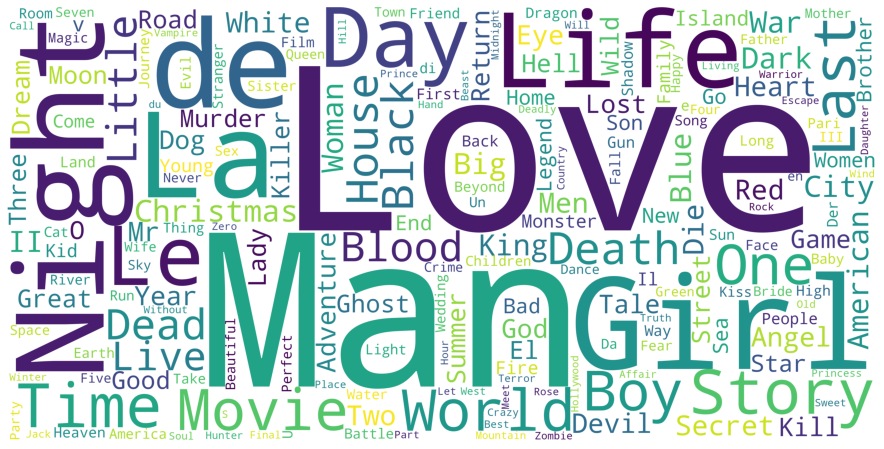

In [37]:
#Create the wordcloud
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
#plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word Love is the most commonly used word in movie titles. Girl, Day and Man are also among the most commonly occuring words. We think this encloses the idea of the universal presence of romance in movies pretty well.

####  Most common Genres

Using the df_movies data, which includes information on the genres each movie is categorised into, we can visualise which genres have the greatest number of movies. While this is not necessarily reflective of which genres are the most popular, it can give us an idea of what is contained within our data.

In [40]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(df_movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
#movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])

movies_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


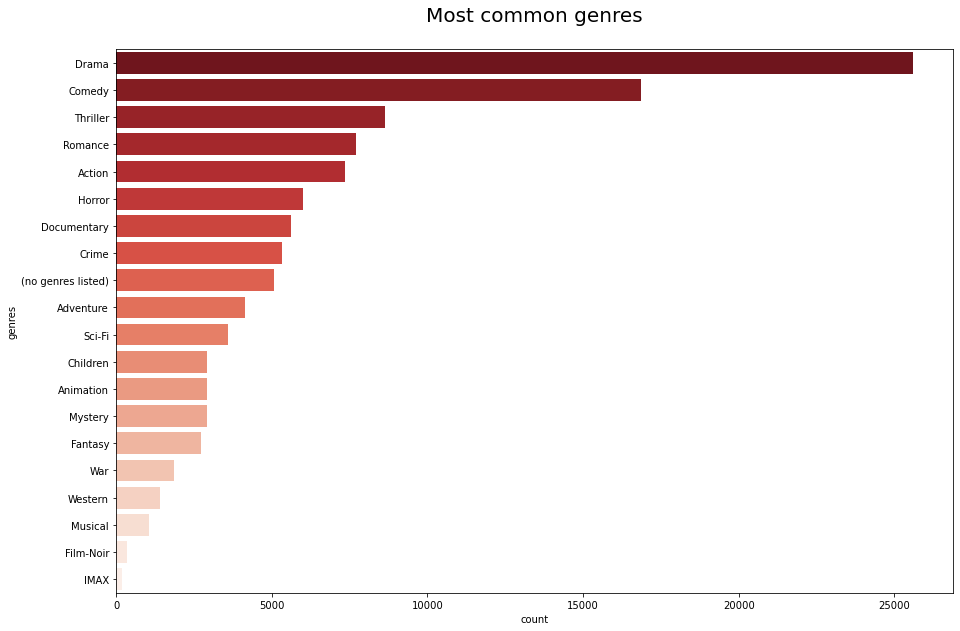

In [41]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

#### Numbers of movies by year

The dataset available to us does not present an entire collection of movies released since the inception of cinema. However, it is reasonable to assume that it does include almost every major film released in Hollywood as well as other major film industries across the world (such as Bollywood in India). With this assumption in mind, let us take a look at the number of movies produced by the year.

<AxesSubplot:xlabel='year'>

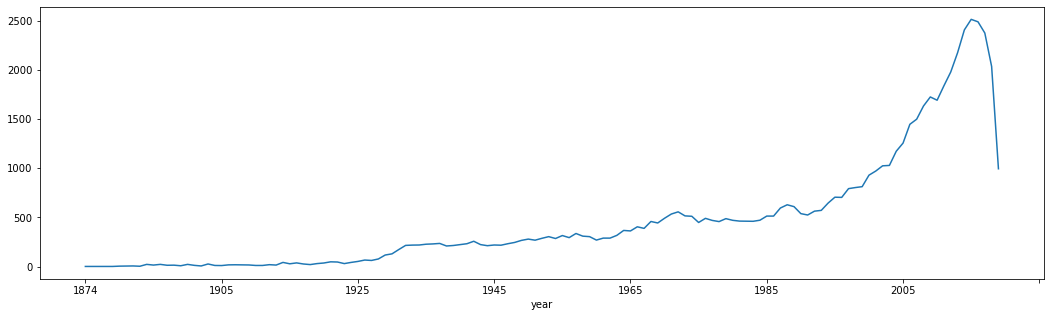

In [42]:
#checking numbers of movies by year
year_count = df_movies.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

We notice that there is a sharp rise in the number of movies starting the 1990s decade. However, we will not look too much into this as it is entirely possible that recent movies were oversampled for the purposes of this dataset.

Next, let us take a look at the earliest movies represented in the dataset.

In [43]:
df_movies[df_movies['year'] != 'NaT'][['title', 'year']].sort_values('year').head(10)

,title,year
35536,Passage de Venus,1874
35533,Sallie Gardner at a Gallop,1878
59938,Athlete Swinging a Pick,1880
43771,Buffalo Running,1883
35529,Man Walking Around a Corner,1887
35530,Accordion Player,1888
48528,Roundhay Garden Scene,1888
35534,Traffic Crossing Leeds Bridge,1888
50210,Pferd und Reiter Springen Über ein Hindernis,1888
35535,London's Trafalgar Square,1890


The oldest movie, Passage of Venus, was a series of photographs of the transit of the planet Venus across the Sun in 1874. This shows how the movies industry has evolved over the year to what it is now.

### Exploratory data analysis on the Imdb dataset

In [44]:
df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


 #### Runtime

In [47]:
df_imdb['runtime'].describe()

count    15189.000000
mean       100.312331
std         31.061707
min          1.000000
25%         89.000000
50%         98.000000
75%        109.000000
max        877.000000
Name: runtime, dtype: float64

The average length of a movie is about 1 hour and 30 minutes. The longest movie on record in this dataset is a staggering 877 minutes (15 hours) long.

We are aware that most movies(mainstream movies) are less than 5 hours (or 300 minutes) long.Below we plottin a distribution of these mainstream movies

<AxesSubplot:xlabel='runtime', ylabel='Density'>

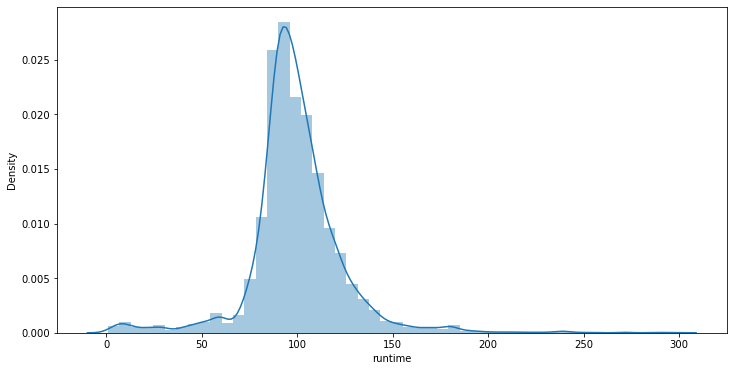

In [48]:
#plot showing distribution of mainstream movies
df_imdb['runtime'] = df_imdb['runtime'].astype('float')
plt.figure(figsize=(12,6))
sns.distplot(df_imdb[(df_imdb['runtime'] < 300) & (df_imdb['runtime'] > 0)]['runtime'])

This plot shows that the average runtime of mainstream movies is at around 60 to 150 minutes

#### Ratings Distribution

We can also explore the distribution of ratings across the data, to see which ratings are given most often, and which least often.

In [22]:
#creating ratings dataframe
ratings = pd.DataFrame(df_train[['rating']],
                             columns=['rating'])

ratings.head()

,rating
0,4.0
1,4.5
2,5.0
3,2.0
4,3.0


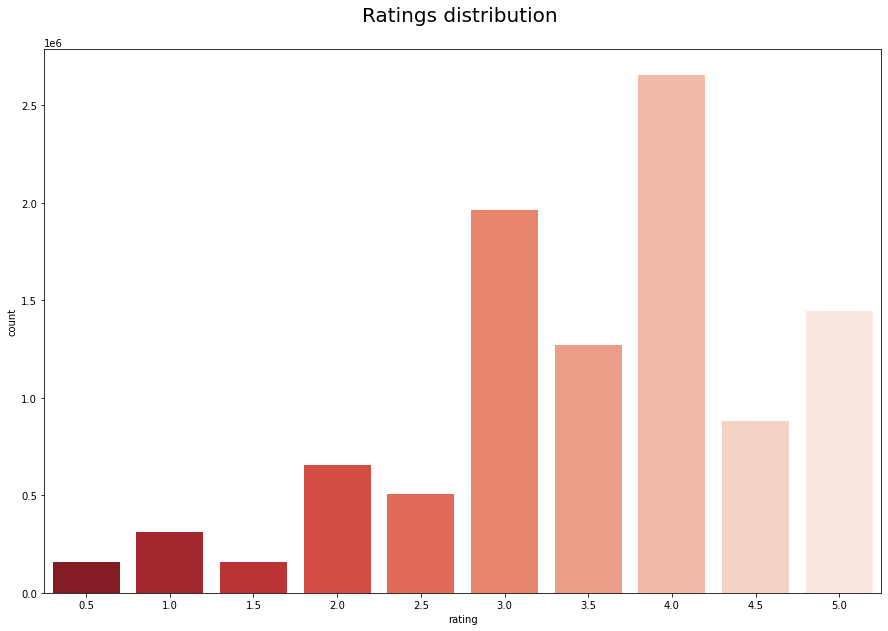

In [23]:
#plot ratings distribution
plt.figure(figsize=(15, 10))
plt.title('Ratings distribution \n', fontsize=20)
sns.countplot(x="rating", data=ratings,
              palette='Reds_r')
plt.show()

#### Number of ratings per genre

The countplot shows more movies are given ratings of 4.0 and 3.0, and fewer movies are given ratings of 0.5 and 1.5. This indicates that the movies in this dataset are often given average to good ratings, with fewer movies being rated poorly.

In [57]:
df_moviestrain_genresep=df_moviestrain.explode('genres', ignore_index=True)
df_moviestrain_genresep.head()

,movieId,title,genres,year,userId,rating
0,1,Toy Story,Adventure,1995,158849,5.0
1,1,Toy Story,Animation,1995,158849,5.0
2,1,Toy Story,Children,1995,158849,5.0
3,1,Toy Story,Comedy,1995,158849,5.0
4,1,Toy Story,Fantasy,1995,158849,5.0


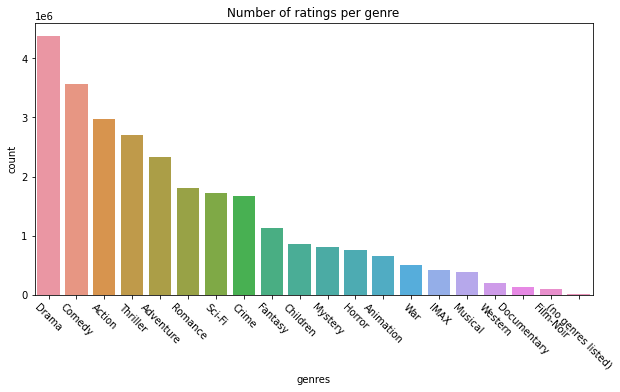

In [58]:
plt.subplots(figsize=(10,5))
sns.countplot(x='genres', order = df_moviestrain_genresep['genres'].value_counts().index, data=df_moviestrain_genresep);
plt.xticks(rotation=-45)
plt.title('Number of ratings per genre');

#### Ratings per Movie

Another aspect of the data we can explore is how many ratings there are per movie. As there are many movies in the dataset, how many of these actually have ratings from a lot of users?

In [59]:
#Because there are so many movies in the database, we clip it at 100, otherwise the graph becomes too difficult to read
ratings_per_movie = pd.DataFrame(df_train.groupby('movieId')['rating'].count().clip(upper=100))
ratings_per_movie.groupby('rating')['rating'].count()

rating
1      12537
2       6515
3       3710
4       2469
5       1780
       ...  
96        32
97        23
98        25
99        21
100     7306
Name: rating, Length: 100, dtype: int64

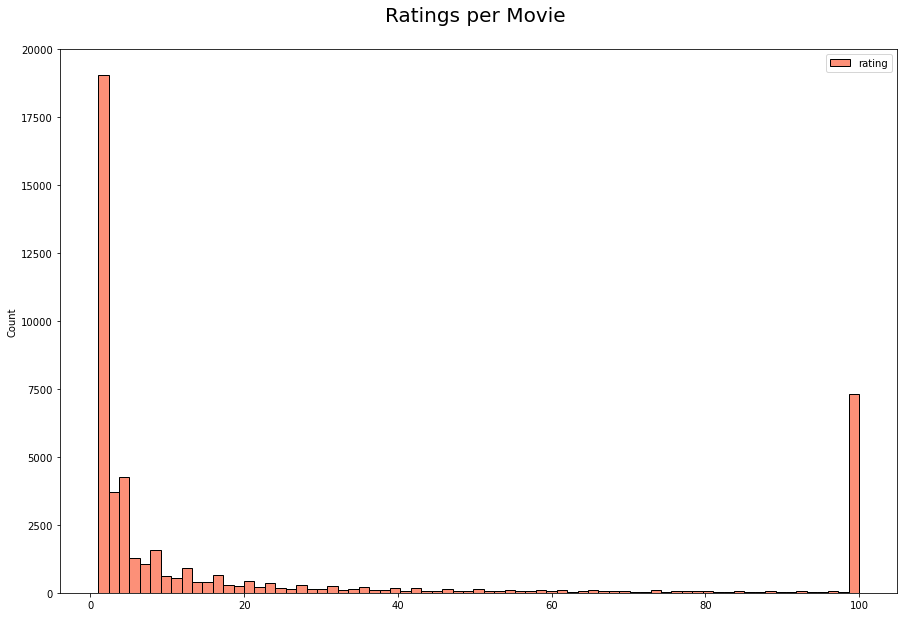

In [60]:
plt.figure(figsize=(15, 10))
plt.title('Ratings per Movie \n', fontsize=20)
sns.histplot(data=ratings_per_movie,
              palette='Reds_r')
plt.show()

The histogram shows us that a vast majority of the movies (12537 movies) only have one rating. We can see that as the number of ratings per movie increases, the count of movies decreases, indicating that few movies have been rated by a large number of users.

#### Ratings per User

On the other hand, we can also explore how many users are actually giving ratings to movies.

In [25]:
#Again, clipped at 500 because there are so many users, that including them all would make the graph difficult to read
ratings_per_user = pd.DataFrame(df_train.groupby('userId')['rating'].count().clip(upper=500))
ratings_per_user.groupby('rating')['rating'].count()

rating
1         6
2        37
3       135
4       440
5      1088
       ... 
496       4
497       9
498      13
499       6
500    1558
Name: rating, Length: 500, dtype: int64

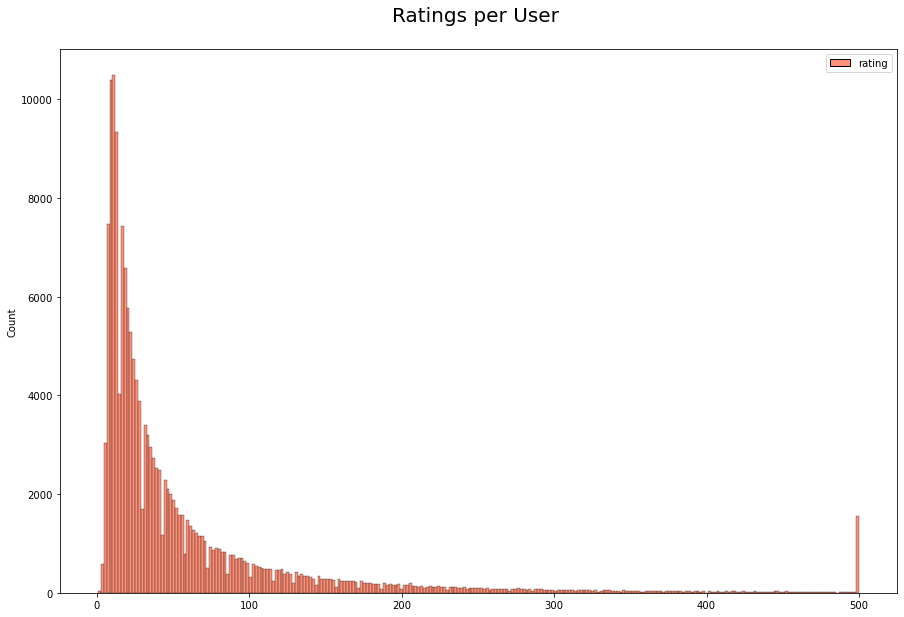

In [26]:
#ratings per user plot
plt.figure(figsize=(15, 10))
plt.title('Ratings per User \n', fontsize=20)
sns.histplot(data=ratings_per_user,
              palette='Reds_r')
plt.show()

Similarly to the previous graph, we can see that the count of users dwindles as the number of ratings per user increases. Quite a lot of users appear to have given between 1 and 100 ratings, but increasingly fewer have given more ratings than this.

#### Top ten rated movies

In [8]:
#merge movies and trains datasets
df_moviestrain = pd.merge(df_movies,df_train)
#drop columns we don't need
df_moviestrain = df_moviestrain.drop(['genres','timestamp'] , axis = 1)
df_moviestrain.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),158849,5.0
1,1,Toy Story (1995),97203,5.0
2,1,Toy Story (1995),161871,3.0
3,1,Toy Story (1995),45117,4.0
4,1,Toy Story (1995),27431,5.0


In [10]:
top_rated_movies = df_moviestrain.groupby('title')['rating'].mean()
#top_rated_movies.head()

In [11]:
top_rated_movies = pd.DataFrame(top_rated_movies)
top_rated_movies = top_rated_movies.reset_index()
#df_top_directors.head()

In [12]:
#read top ten rated movies
top_rated_movies = top_rated_movies.sort_values(by='rating', ascending = False)
top_rated_movies = top_rated_movies[:10]
top_rated_movies

,title,rating
46553,Which Way Home (2009),5.0
20988,Kaakha Kaakha (2003),5.0
28142,Not Quite Human II (1989),5.0
34059,Selling Isobel (2018),5.0
34037,Sehar (2005),5.0
39402,The Enchanted Sedan Chair (1905),5.0
20978,K.G.F: Chapter 1 (2018),5.0
17023,Hard Cash (2002),5.0
12979,Everyone's Going to Die (2013),5.0
2933,Anything for Love (2016),5.0


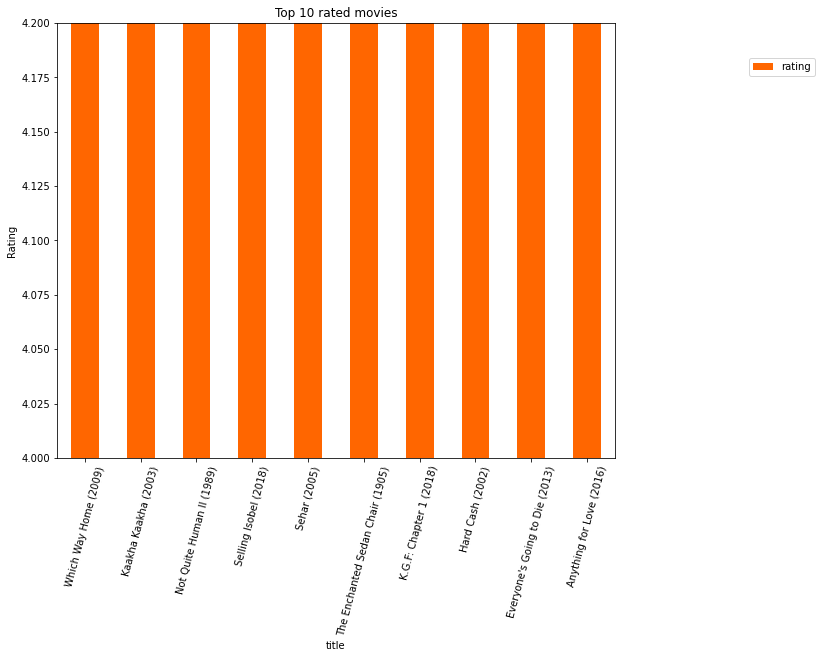

In [13]:
#top rated movies plot
ax = top_rated_movies.plot.bar(x='title', y=['rating'] , title='Top 10 rated movies' , rot =75 , color = '#ff6600', figsize=(10,8))
ax.set_xlabel('title')
ax.set_ylabel('Rating')
ax.set_ylim(4,4.2)
plt.legend(loc=10, bbox_to_anchor=(1.3, .9), ncol=1)
plt.show()

This plot displays the top ten rated movoes base on user rating. They all had the 5 Start rating which is  odd,we think this is because not many user rate movies.

In [15]:
#merge the imdb and train dataset
df_imdbtrain = pd.merge(df_imdb,df_train)
#drop columns we won't need
df_imdbtrain = df_imdbtrain.drop(['budget','runtime','title_cast','plot_keywords'] , axis = 1)
df_imdbtrain.head()

,movieId,director,userId,rating,timestamp
0,1,John Lasseter,158849,5.0,994716786
1,1,John Lasseter,97203,5.0,942683155
2,1,John Lasseter,161871,3.0,833104576
3,1,John Lasseter,45117,4.0,1442256969
4,1,John Lasseter,27431,5.0,849667827


In [16]:
top_rated_directors = df_imdbtrain.groupby('director')['rating'].mean()
#top_rated_movies.head()

In [17]:
top_rated_directors = pd.DataFrame(top_rated_directors)
top_rated_directors = top_rated_directors.reset_index()
#df_top_directors.head()

In [18]:
#read top ten rated movies
top_rated_directors = top_rated_directors.sort_values(by='rating', ascending = False)
top_rated_directors = top_rated_directors[:10]
top_rated_directors

,director,rating
8013,Robert W. Allan,5.0
9208,Till Schauder,5.0
7259,Paul Osborne,5.0
9519,Valarie Trapp,5.0
9020,T Bone Burnett,5.0
7729,Ric Klass,5.0
8064,Roger Avon,5.0
7689,Rebecca Cammisa,5.0
6736,Mushon Salmona,5.0
4896,Joshua Sinclair,5.0


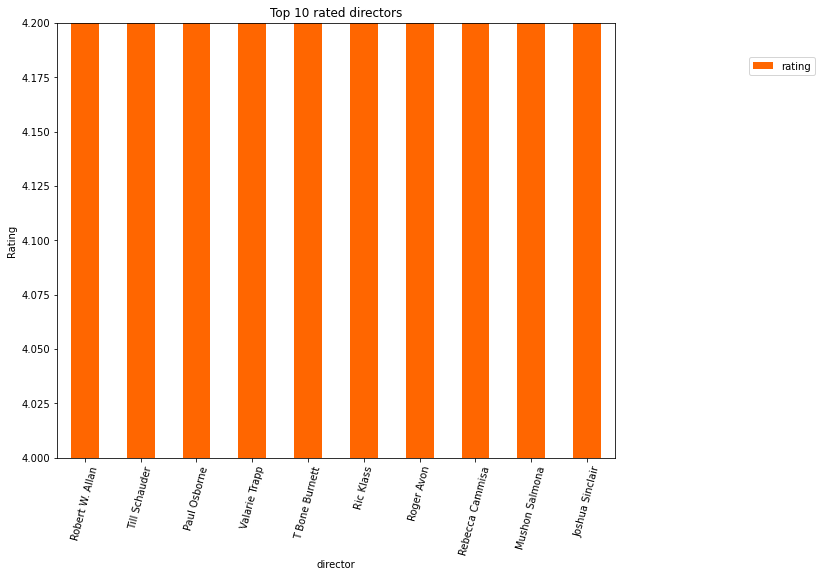

In [20]:
#top rated director plot
ax = top_rated_directors.plot.bar(x='director', y=['rating'] , title='Top 10 rated directors' , rot =75 , color = '#ff6600', figsize=(10,8))
ax.set_xlabel('director')
ax.set_ylabel('Rating')
ax.set_ylim(4,4.2)
plt.legend(loc=10, bbox_to_anchor=(1.3, .9), ncol=1)
plt.show()

Similarly with the presvious graph this graph shows top ten rated directors which are all rated at 5 stars,probably because there was missing values in the imdb dataset or only a few people rated the directors

# Data Preparation

Since keeping genres in a list format isn't optimal for the content-based recommendation system technique, we will use the One Hot Encoding technique to convert the list of genres to a vector where each column corresponds to one possible value of the feature. This encoding is needed for feeding categorical data. In this case, we store every different genre in columns that contain either 1 or 0. 1 shows that a movie has that genre and 0 shows that it doesn't. Let's also store this dataframe in another variable since genres won't be important for our first recommendation system.

In [63]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.
moviesWithGenres_df = df_movies.copy()

#For every row in the dataframe, iterate through the list of genres and place a 1 into the corresponding column
for index, row in df_movies.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1
#Filling in the NaN values with 0 to show that a movie doesn't have that column's genre
moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now let's look at the ratings.

In [64]:
df_train.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


Every row in the df_train dataframe has a user id associated with at least one movie. Here, we do not need the timestamp of when the users reviewed the movie. So, let's drop the 'timestamp' column.

In [66]:
#df_train = df_train.drop('timestamp', 1)

In [67]:
df_train.head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


# Content-Based Recomendation System

This filtering is done based on the product's description or certain data. Based on their description or context, the system determines whether two recommended things are comparable. The user's previous preferences are taken into account when recommending things that they could enjoy in the future. For example, if a customer enjoys films like "Toy story" we can suggest "Jumanji" since both are family movies.

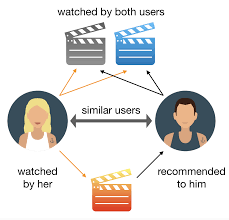

## Let's begin by creating an input user to recommend movies to:

Notice: To add more movies, simply increase the amount of elements in the userInput. Feel free to add more in! Just be sure to write it in with capital letters and if a movie starts with a "The", like "The Matrix" then write it in like this: 'Matrix, The' .

In [68]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


In [69]:
#Filtering out the movies by title
inputId = df_movies[df_movies['title'].isin(inputMovies['title'].tolist())]
#Then merging it so we can get the movieId. It's implicitly merging it by title.
inputMovies = pd.merge(inputId, inputMovies)
#Dropping information we won't use from the input dataframe
inputMovies = inputMovies.drop('genres', 1).drop('year', 1)
#Final input dataframe
#If a movie you added in above isn't here, then it might not be in the original 
#dataframe or it might spelled differently, please check capitalisation.
inputMovies

,movieId,title,rating
0,1,Toy Story,3.5
1,2,Jumanji,2.0
2,296,Pulp Fiction,5.0
3,1274,Akira,4.5
4,164600,Akira,4.5
5,1968,"Breakfast Club, The",5.0


In [70]:
#Filtering out the movies from the input
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
292,296,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1241,1274,Akira,"[Action, Adventure, Animation, Sci-Fi]",1988,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1879,1968,"Breakfast Club, The","[Comedy, Drama]",1985,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42774,164600,Akira,"[Action, Crime, Thriller]",2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We'll only need the actual genre table, so let's clean this up a bit by resetting the index and dropping the movieId, title, genres and year columns.

In [71]:
#Resetting the index to avoid future issues
userMovies = userMovies.reset_index(drop=True)
#Dropping unnecessary issues due to save memory and to avoid issues
userGenreTable = userMovies.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we're ready to start learning the input's preferences!

To do this, we're going to turn each genre into weights. We can do this by using the input's reviews and multiplying them into the input's genre table and then summing up the resulting table by column. This operation is actually a dot product between a matrix and a vector, so we can simply accomplish by calling Pandas's "dot" function.

In [72]:
inputMovies['rating']

0    3.5
1    2.0
2    5.0
3    4.5
4    4.5
5    5.0
Name: rating, dtype: float64

In [73]:
#Dot produt to get weights
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
#The user profile
userProfile

Adventure             10.0
Animation              8.0
Children               5.5
Comedy                13.0
Fantasy                5.5
Romance                0.0
Drama                  9.5
Action                 9.5
Crime                 10.0
Thriller              10.0
Horror                 0.0
Mystery                0.0
Sci-Fi                 4.5
IMAX                   0.0
Documentary            0.0
War                    0.0
Musical                0.0
Western                0.0
Film-Noir              0.0
(no genres listed)     0.0
dtype: float64

Now, we have the weights for every of the user's preferences. This is known as the User Profile. Using this, we can recommend movies that satisfy the user's preferences.

Let's start by extracting the genre table from the original dataframe:

In [74]:
#Now let's get the genres of every movie in our original dataframe
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
#And drop the unnecessary information
genreTable = genreTable.drop('movieId', 1).drop('title', 1).drop('genres', 1).drop('year', 1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
genreTable.shape

(62423, 20)

With the input's profile and the complete list of movies and their genres in hand, we're going to take the weighted average of every movie based on the input profile and recommend the top twenty movies that most satisfy it.

In [76]:
#Multiply the genres by the weights and then take the weighted average
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df.head()

movieId
1    0.491228
2    0.245614
3    0.152047
4    0.263158
5    0.152047
dtype: float64

In [77]:
#Sort our recommendations in descending order
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
#Just a peek at the values
recommendationTable_df.head()

movieId
5018      0.730994
144324    0.725146
64645     0.725146
81132     0.725146
122787    0.725146
dtype: float64

Now here's the recommendation table!

In [78]:
#The final recommendation table
df_movies.loc[df_movies['movieId'].isin(recommendationTable_df.head(10).keys())]

,movieId,title,genres,year
4614,4719,Osmosis Jones,"[Action, Animation, Comedy, Crime, Drama, Roma...",2001
4912,5018,Motorama,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",1991
9177,27344,Revolutionary Girl Utena: Adolescence of Utena...,"[Action, Adventure, Animation, Comedy, Drama, ...",1999
12879,64645,The Wrecking Crew,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1968
15389,81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010
22553,115479,"Whip Hand, The","[Action, Adventure, Crime, Drama, Sci-Fi, Thri...",1951
23306,117646,Dragonheart 2: A New Beginning,"[Action, Adventure, Comedy, Drama, Fantasy, Th...",2000
25008,122787,The 39 Steps,"[Action, Adventure, Comedy, Crime, Drama, Thri...",1959
33940,144324,Once Upon a Time,"[Action, Adventure, Comedy, Crime, Drama, Roma...",2008
36115,149488,Christmas Town,"[Action, Children, Comedy, Drama, Fantasy, Thr...",2008


Although content-based recommender systems are highly personalized for the user and they learn the user's preferences, one major disadvantage of them is that they don't take into account of what others may think of the item. So low quality recommendations may happen. This is where collaborative filtering steps in to resolve this problem.

#### Disadvantages of content based filtering

Although content-based recommender systems are highly personalized for the user and they learn the user's preferences, some of the disadvantages it has include:

- they don't take into account of what others may think of the item. So low quality recommendations may happen. This is where collaborative filtering steps in to resolve this problem.
- Limited content analysis: If the content doesn’t contain enough information to discriminate the items precisely, the recommendation itself risks being imprecise.
- Over-specialization: Content-based filtering provides a limited degree of novelty since it has to match up the features of a user’s profile with available items. In the case of item-based filtering, only item profiles are created and users are suggested items similar to what they rate or search for, instead of their history. A perfect content-based filtering system may suggest nothing unexpected or surprising.

# Collaborative Filtering

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions. There are many ways to decide which users are similar and combine their choices to create a list of recommendations. 

**There are two classes of Collaborative Filtering:**
- User-based, which measures the similarity between target users and other users.
- Item-based, which measures the similarity between the items that target users rate or interact with and other items.


<img src="https://miro.medium.com/max/1838/1*3ALliiz9hG79_2xopzgyrQ.png" width=800px>

Although collaborative Filtering is very commonly used in recommenders, some of the challenges that are faced while using it are the following:

- Collaborative filtering can lead to some problems like cold start for new items that are added to the list. Until someone rates them, they don’t get recommended.

- Data sparsity can affect the quality of user-based recommenders and also add to the cold start problem mentioned above.

#### User-based recommendation system
There are several methods of finding similar users (Even some making use of Machine Learning), and the one we will be using here is going to be based on the __Pearson Correlation Function__.

**The process for creating a User Based recommendation system is as follows:**
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours 
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score

Let's also drop the genres column since we won't need it for this particular recommendation system.

In [79]:
#Dropping the genres column
df_movies = df_movies.drop('genres', 1)

In [80]:
df_movies.head()

,movieId,title,year
0,1,Toy Story,1995
1,2,Jumanji,1995
2,3,Grumpier Old Men,1995
3,4,Waiting to Exhale,1995
4,5,Father of the Bride Part II,1995


#### The users who has seen the same movies
Now with the movie ID's in our input, we can now get the subset of users that have watched and reviewed the movies in our input.

In [81]:
#Filtering out users that have watched movies that the input has watched and storing it
userSubset = df_train[df_train['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
82,121814,296,5.0
119,158849,1,5.0
154,97203,1,5.0
194,161871,1,3.0
416,59292,296,5.0


We now group up the rows by user ID.

In [82]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
userSubsetGroup = userSubset.groupby(['userId'])

Let's look at one of the users, say the one with a userId == 97088.

In [83]:
userSubsetGroup.get_group(97088)

,userId,movieId,rating
71964,97088,296,4.5
5959462,97088,2,1.0
9999845,97088,1274,5.0


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [84]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Let's look at the first 3 users.

In [85]:
userSubsetGroup[0:3]

[(43983,
           userId  movieId  rating
  3066576   43983      296     5.0
  3334368   43983     1274     2.5
  4538439   43983     1968     2.5
  7186741   43983        1     0.5
  7434828   43983        2     0.5),
 (47001,
           userId  movieId  rating
  3023697   47001        2     4.0
  4198905   47001      296     3.0
  5151252   47001     1274     3.5
  8291091   47001        1     4.0
  8408923   47001     1968     1.5),
 (48197,
           userId  movieId  rating
  810484    48197        2     3.5
  1619555   48197        1     5.0
  1673286   48197      296     5.0
  1721958   48197     1274     4.0
  6148121   48197     1968     4.5)]

#### Similarity of users to input user
Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.  
we're going to find out how similar each user is to the input through the __Pearson Correlation Coefficient__. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below. 

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation")

The values given by the formula vary from r = -1 to r = 1, where 1 forms a direct correlation between the two entities (it means a perfect positive correlation) and -1 forms a perfect negative correlation. 

In our case, a 1 means that the two users have similar tastes while a -1 means the opposite.

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [86]:
userSubsetGroup = userSubsetGroup[0:100]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient

In [87]:
from math import sqrt

In [88]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    #Get the N for the formula
    nRatings = len(group)
    #Get the review scores for the movies that they both have in common
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0

In [89]:
pearsonCorrelationDict.items()

dict_items([(43983, 0.7918903339499381), (47001, -0.7093169886164387), (48197, 0.6016568375961863), (54125, 0.986690271720408), (57946, 0.2508726030021272), (76334, 0.8713121398246098), (96495, 0.8360171835451685), (117801, 0.774023530673005), (120443, 0.7674257668936518), (120901, 0.4688072309384956), (125551, 0.8272781516947562), (137196, -0.5709161420029026), (138487, 0.7844645405527362), (150141, -0.2632248664483318), (159612, 0.6020183016345595), (265, -0.16116459280507606), (321, 1.0), (3394, 0.2548235957188128), (3777, -0.7112655491946736), (4006, 0.4364357804719848), (4950, 0.5606119105813882), (5019, 0.9028289727756884), (6118, -0.8553372034476997), (7540, 0.8021806287494233), (8150, 0.4923659639173309), (8641, -0.899228803025897), (10106, 0.8181818181818182), (10357, -0.8280786712108251), (10496, 0.8181818181818182), (10508, 0.9438798074485389), (10717, -0.6225728063646904), (11491, -0.9847319278346618), (11778, 0.9864400504156211), (11952, 0.19069251784911845), (12274, 0.426

As we can see, this dictionary is an eyesore and it is better to have the values stored in a dataframe.

In [90]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.791890,43983
1,-0.709317,47001
2,0.601657,48197
3,0.986690,54125
4,0.250873,57946


#### The top x similar users to input user
Now let's get the top 50 users that are most similar to the input.

In [91]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
16,1.000000,321
53,0.995910,25619
89,0.994334,47745
3,0.986690,54125
32,0.986440,11778


Great, now then let's start recommending some movies to the input user.

#### Rating of selected users to all movies
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our __pearsonDF__ from the train dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [92]:
topUsersRating=topUsers.merge(df_train, left_on='userId', right_on='userId', how='inner')
topUsersRating.head()

,similarityIndex,userId,movieId,rating
0,1.0,321,1127,4.0
1,1.0,321,500,3.0
2,1.0,321,1977,4.0
3,1.0,321,1573,3.0
4,1.0,321,4270,1.5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [93]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,movieId,rating,weightedRating
0,1.0,321,1127,4.0,4.0
1,1.0,321,500,3.0,3.0
2,1.0,321,1977,4.0,4.0
3,1.0,321,1573,3.0,3.0
4,1.0,321,4270,1.5,1.5


In [94]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movieId,,
1,34.441227,127.245038
2,38.408649,100.807202
3,4.050568,8.377308
4,0.574427,0.574427
5,3.006241,5.849623


In [95]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,3.694556,1
2,2.624596,2
3,2.068181,3
4,1.000000,4
5,1.945826,5


Now let's sort the recommendation dataframe and see just the top 10 movies that the algorithm recommended. 

In [96]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

,weighted average recommendation score,movieId
movieId,,
3260,5.0,3260
1728,5.0,1728
7577,5.0,7577
7936,5.0,7936
26350,5.0,26350
775,5.0,775
8239,5.0,8239
1889,5.0,1889
6828,5.0,6828


We need to make the recommended movies more recognizable.

In [97]:
df_movies.loc[df_movies['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,year
759,775,Spirits of the Dead,1968
1662,1728,"Winter Guest, The",1997
1800,1889,Insomnia,1997
3167,3260,Howards End,1992
6705,6828,"Sunday in the Country, A (Un dimanche à la cam...",1984
6964,7089,Amarcord,1973
7363,7577,"Magic Flute, The (Trollflöjten)",1975
7546,7936,Shame (Skammen),1968
7688,8239,Viridiana,1961
8757,26350,"Passenger, The (Professione: reporter)",1975


# Modelling

As our dataset is so large (10 million rows!), in order to test models from the surprise package, we use a subset of the data to train and evaluate each of these models to get an indication of which performs best. We will use a subset of 1 million data points.

In [98]:
df_train_1M = df_train.sample(1000000)

In [99]:
from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(df_train_1M[['userId', 'movieId', 'rating']], reader)

In [100]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.25)

### SVD

The Singular Value Decomposition (SVD), a method from linear algebra that has been generally used as a dimensionality reduction technique in machine learning. SVD is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K<N). In the context of the recommender system, the SVD is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

In [ ]:
from surprise import SVD, accuracy
algo = SVD(n_factors=2)
algo.fit(trainset)

In [ ]:
predictions = algo.test(testset)
svd_rmse = accuracy.rmse(predictions)


#svd_rmse = 0.9002

We get a mean Root Mean Square Error of 0.85 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [ ]:
# trainset = data.build_full_trainset()
# svd.fit(trainset)

Now let's use SVD to predict the rating that, for instance, a User with ID 150 will give to a random movie (let's say with Movie ID 1000).

In [ ]:
# svd.predict(150, 1000)

For a movie with movieId 1000, User with ID 150 is predicted to give a rating of 3.3.

### SVD++

In [ ]:
# from surprise.model_selection import train_test_split

# trainset, testset = train_test_split(data, test_size=0.25)

In [ ]:
# algo_svdpp = SVDpp(n_factors=160, n_epochs=10, lr_all=0.005, reg_all=0.1)
# algo_svdpp.fit(trainset)
# test_pred = algo_svdpp.test(testset)

### Baseline Only

A baseline is a method that uses heuristics, simple summary statistics, randomness, or machine learning to create predictions for a dataset.The purpose of using a baseline when evaluating a machine learning model algorithm is to provides a set of predictions that you can evaluate as you would any predictions for your problem, such as classification accuracy or RMSE

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 35}
blo = BaselineOnly(bsl_options=bsl_options)
blo.fit(trainset)
predictions = blo.test(testset)
blo_rmse = accuracy.rmse(predictions)

#blo_rmse = 0.9022

### SlopeOne

Slope one algorithm is a special form of Item-based collaborative filtering algorithm, which has the characteristics of easy to use, accurate recommendation and high computational efficiency.

In [ ]:
# SlopeOne
slo_test = SlopeOne()
slo_test.fit(trainset)
predictions = slo_test.test(testset)
# Calculate RMSE
slo_rmse = accuracy.rmse(predictions)

#slo_rmse = 1.0492

### NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised algorithm that projects data into lower dimensional spaces, effectively reducing the number of features while retaining the basis information necessary to reconstruct the original data

In [ ]:
nmf = NMF()
nmf.fit(trainset)
nmf_p = nmf.test(testset)
nmf_rmse = accuracy.rmse(nmf_p)

#nmf_rmse = 1.0317

### Normal Predictor

NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

In [ ]:
np = NormalPredictor()
np.fit(trainset)
np_p = np.test(testset)
np_rmse = accuracy.rmse(np_p)

#np_rmse = 1.4378

### CoClustering

Co-clustering simultaneously cluster both data points and features of a two-dimensional data matrix. It is a powerful data analysis technique that can discover latent patterns hidden within particular rows and columns

In [ ]:
cc = CoClustering(random_state=42)
cc.fit(trainset)
cc_p = cc.test(testset)
cc_rmse = accuracy.rmse(cc_p)

#cc_rmse = 1.0140

In [ ]:
#Log parameters and metrics in Comet, end experiment

#params = {"model_type": "CoClustering",
#          "sample size": "1M",
#          }
#metrics = {"rmse": cc_rmse
#           }

#experiment.log_parameters(params)
#experiment.log_metrics(metrics)

#experiment.end()

## Model Evaluation

We built and tested different types of collaborative filtering models . Their performance was compared using a statistical measure known as the root mean squared error (RMSE), which determines the average squared difference between the estimated values and the actual value. A low RMSE value indicates high model accuracy.

### Root Mean Squared Error (RMSE):

$$RMSE = \sqrt{\frac{1}{|\hat{R}|}\Sigma_{r_{ui} \in {\hat{R}}}{\Big({r_{ui} -{\hat {r}}_{ui}}\Big)^2}}$$

Where  ${\hat{R}}$   is the total number of recommendations generated for users and movies, with $r_{ui}$  and  ${\hat {r}}_{ui}$ 𝑢𝑖  being the true and predicted ratings for user u watching movie i respectively.

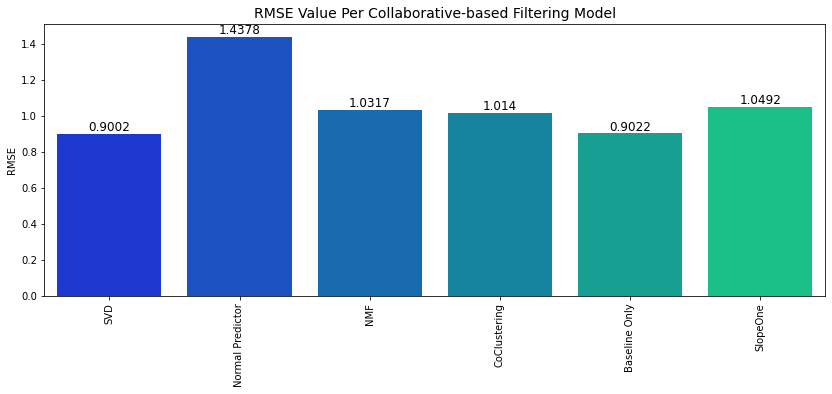

In [4]:
# Compare RMSE Between Models
fig,axis = plt.subplots(figsize=(14, 5))
models = ['SVD','Normal Predictor','NMF','CoClustering','Baseline Only','SlopeOne']
#rmse_y = [svd_rmse,np_rmse,nmf_rmse,cc_rmse,blo_rmse,slo_rmse]
rmse_y = [0.9002, 1.4378, 1.0317, 1.0140, 0.9022, 1.0492]
ax = sns.barplot(x=models, y=rmse_y,palette='winter')
plt.title('RMSE Value Per Collaborative-based Filtering Model',fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height(), round(p.get_height(),4), 
            fontsize=12, ha="center", va='bottom')
    
plt.show()

### Cross Validation

Cross-Validation also referred to as out of sampling technique is an essential element of a data science project. It is a resampling procedure used to evaluate machine learning models and access how the model will perform for an independent test dataset.We have used this technique as it can assist in picking up issues such as over/underfitting and selection bias. The K-fold technique is used to perform cross validation. The technique is applied on the best two perfoming models, SVD and BaselineOnly.

In [ ]:
svd_test = SVD(n_epochs = 50, n_factors = 300, init_std_dev = 0.05, random_state=42)
# Run 5-fold cross-validation and print results
a = cross_validate(svd_test, data, measures=['RMSE'], cv=5, verbose=True)

In [ ]:
bsl_options = {'method': 'sgd','n_epochs': 40}
blo_test = BaselineOnly(bsl_options=bsl_options)
# Run 5-fold cross-validation and print results
b = cross_validate(blo_test, data, measures=['RMSE'], cv=5, verbose=True)

### Hyperparameter tuning

Hyper parameter tuning is the process of selecting the ideal set of hyperparameters for the model. The hyperparameter is a parameter for which the value is set manually and tuned to control the learning process of the algorithm. We tested several parameters for our optimal performance model SVD.

In [ ]:
# gridsearch on svd
param_grid = {'n_epochs':[50],#[40,30,40,50],
              'n_factors':[1000],#[300,400,500,1000,1500],
              'init_std_dev':[0.005],#,0.001,0.005,0.05,0.1],
              'random_state':[42]} 
grid_SVD = GridSearchCV(SVD, cv=5, measures=['rmse'], param_grid=param_grid, n_jobs=-1)
grid_SVD.fit(trainset)
print('Best score:')
print(grid_SVD.best_score['rmse'])
print('Best parameters:')
print(grid_SVD.best_params['rmse'])

In [ ]:
svd_test = SVD(n_epochs = 50, n_factors = 1000, init_std_dev = 0.005, random_state=42)
svd_test.fit(trainset)
predictions = svd_test.test(testset)
# Calculate RMSE
svd_rmse = accuracy.rmse(predictions)

In [ ]:
# test predictions
predictions = []
for i, row in df_test.iterrows():
    x = (svd_test.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)

In [ ]:
df_test['Id'] =df_test['userId'].map(str) +'_'+ df_test['movieId'].map(str)
results = pd.DataFrame({"Id":df_test['Id'],"rating": predictions})
results.to_csv("Team JS1-Unsupervised.csv", index=False)

### Submission

In [ ]:
# test predictions
predictions = []
for i, row in df_test.iterrows():
    x = (algo.predict(row.userId, row.movieId))
    pred = x[3]
    predictions.append(pred)

In [ ]:
df_test['Id'] =df_test['userId'].map(str) +'_'+ df_test['movieId'].map(str)
results = pd.DataFrame({"Id":df_test['Id'],"rating": predictions})
results.to_csv("Team JS1-Unsupervised.csv", index=False)

## Conclusion

We have ve built a system that can recommend movies based on content-based and collaborative filtering algorithm, this system can accurately predict how a user will rate a movie they have not yet viewed based on their historical preferences.One of the problems of building a recommender system using collaborative filtering is that collaborative filtering relies only on user-item interactions within the utility matrix. The issue with this approach is that new users or items with no interactions are not included to the recommendation system. Content-based filtering is implemented to handle this issue as its generate recommendations based on user and item features. Several types of models were trained and the top-performing model has a root mean squared error (RMSE) of 0.8, based on a testing set that was submitted to Kaggle .